# Aerodynamic Splatting

In [1]:
import numpy as np
from sympy import symbols, diff, Quaternion, exp, Matrix, lambdify, sin, cos, simplify, latex
#from sympy.physics.mechanics import *
import random
from IPython.display import display
import matplotlib.pyplot as plt
from aerosplat import *

## Symbolic Math

## Equation for quaternion
We provide two options for obtaining the quaternon.
In the case where a `numpy` array with four quaternion components are provided, we will obtain using the standard syntax `Quaternion(qw, qx, qy, qz)`.
In the case where a single component is provided, we will assume that this is a planar model with an angle evaluated about the $z$-axis, and obtain with the `Quaternion.from_axis_angle` class method.
We also will create the `idx_dimension` variable which shrinks subsequent matrices and vectors to use only the first two ($x$ and $y$) components.

In [2]:
display(quaternion_2d)

cos(θ/2) + 0*i + 0*j + sin(θ/2)*k

In [3]:
display(quaternion_3d)

q_w + q_x*i + q_y*j + q_z*k

## Equation for gaussian

The Gaussian equation that is created below uses the variance term _not-squared_, while in the plot I square this term.
There is reason for this; the variance that I will use below is going to be of the form

$\texttt{variance} = \sum_{i=1}^3 \left( \frac{x_i - \bar{x}_i}{s_i} \right)^2$

where $x_i$ is a position coordinate for where we are measuring, $\bar{x}_i$ is the position coordinate for the center of the Gaussian, and $s_i$ is a scale coefficient representing one standard deviation in the direction of that coordinate.
Traditionally, we would evaluate the Gaussian at some count of standard deviations, which would derive from the square-root of the above expression.
To avoid taking a square-root, just to subsequently square the term again, we create the Gaussian as a function of the variance directly.
However, the plot below shows an evaluation of the Gaussian with respect to standard deviations.

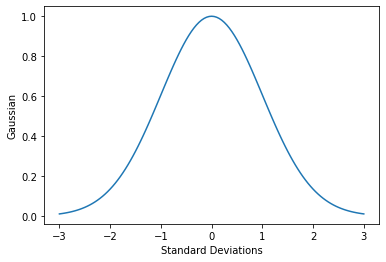

In [4]:
stdev = np.linspace(-3, 3, 121);
plt.plot(stdev, np.exp(-0.5 * stdev**2));
plt.xlabel("Standard Deviations");
plt.ylabel("Gaussian");

Here we create a function that obtains the rotation matrix from the quaternion, along with some simplification steps.
First, we substitute a value of 1 for the quaternion norm, as we will ensure that it is always a proper unit quaternion.
Second, we call the standard `simplify()` function.

In [5]:
display(rotation_eqn_2d)

Matrix([
[cos(θ), -sin(θ)],
[sin(θ),  cos(θ)]])

In [6]:
display(rotation_eqn_3d)
print(latex(rotation_eqn_2d))

Matrix([
[-2*q_y**2 - 2*q_z**2 + 1,   -2*q_w*q_z + 2*q_x*q_y,    2*q_w*q_y + 2*q_x*q_z],
[   2*q_w*q_z + 2*q_x*q_y, -2*q_x**2 - 2*q_z**2 + 1,   -2*q_w*q_x + 2*q_y*q_z],
[  -2*q_w*q_y + 2*q_x*q_z,    2*q_w*q_x + 2*q_y*q_z, -2*q_x**2 - 2*q_y**2 + 1]])

\left[\begin{matrix}\cos{\left(θ \right)} & - \sin{\left(θ \right)}\\\sin{\left(θ \right)} & \cos{\left(θ \right)}\end{matrix}\right]


In [7]:
display(Matrix(velocity_eqn_2d))

Matrix([
[u*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2)],
[v*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2)]])

We see the variance contained in the exponent

In [8]:
display(variance_eqn_2d)

s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 + s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2

### Velocity gradient equations

In [9]:
display(Matrix(variance_gradient_eqn_2d))

Matrix([
[ 2*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*cos(θ) + 2*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*sin(θ)],
[-2*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*sin(θ) + 2*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*cos(θ)]])

In [10]:
display(Matrix(velocity_gradient_eqn_2d))

Matrix([
[u*(-1.0*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*cos(θ) - 1.0*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*sin(θ))*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2)],
[ v*(1.0*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*sin(θ) - 1.0*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*cos(θ))*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2)]])

In [11]:
display(Matrix(velocity_gradient_matrix_eqn_2d))

Matrix([
[u*(-1.0*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*cos(θ) - 1.0*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*sin(θ))*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2), v*(-1.0*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*cos(θ) - 1.0*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*sin(θ))*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2)],
[ u*(1.0*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*sin(θ) - 1.0*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*cos(θ))*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2),  v*(1.0*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))*sin(θ) - 1.0*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))*cos(θ))*exp(-0.5*s_x**2*((-x + x_p)*cos(θ) - (-y + y_p)*sin(θ))**2 - 0.5*s_y**2*((-x + x_p)*sin(θ) + (-y + y_p)*cos(θ))**2)]])

## Splatting Class

In [12]:
a = AeroSplat(
    position=[0, 0], 
    velocity_vector=[1, 0],
    velocity_magnitude=1,
    scale=[1, 1],
    orientation=[0]
)
display(a)
display(a.quaternion)
display(a.rotation_matrix)
rk = np.array([2, 0])
print(a.properties_at(rk))
display(a.velocity_at(rk))
display(a.differential_velocity_at(rk))
display(a.velocity_gradient_at(rk))
display(a.velocity_gradient_matrix_at(rk))

AeroSplat(position=[0 0], velocity=[1. 0.], scale=[1 1], orientation=[0])

1 + 0*i + 0*j + 0*k

array([[ 1., -0.],
       [ 0.,  1.]])

[0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 2, 0]


array([0.13533528, 0.        ])

array([[ 0.27067057,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.13533528,  0.        ],
       [ 0.        ,  0.13533528],
       [-0.54134113, -0.        ],
       [-0.        , -0.        ],
       [-0.        , -0.        ]])

array([-0.27067057, -0.        ])

array([[-0.27067057, -0.        ],
       [ 0.        ,  0.        ]])

## Boundary Condition Class

In [13]:
source_boundary = LineBoundary(point0=[0, -1], point1=[0, 1], velocity=[10, 0])
plate_boundary = LineBoundary(point0=[1, -0.5], point1=[1, 0.5], velocity=[0, 0])
print(source_boundary)
print(source_boundary.point_at_random())

LineBoundary(point0=[ 0 -1], point1=[0 1], velocity=[10  0])
[ 0.         -0.84130087]


## Problem Definition Class

In [14]:
problem = AeroSplatProblem(
    domain_x=[0, 2], 
    domain_y=[-1, 1],
    boundaries=[source_boundary, plate_boundary],
)
print(problem)
display(a.as_normalized_array(problem.domain))
print(AeroSplat.from_normalized_array(a.as_normalized_array(problem.domain), problem.domain))

AeroSplatProblem(
  domain_x=[0 2]
  domain_y=[-1  1]
  boundaries=[LineBoundary(point0=[ 0 -1], point1=[0 1], velocity=[10  0]), LineBoundary(point0=[ 1.  -0.5], point1=[1.  0.5], velocity=[0 0])]
)


[0.0, 0.5, 1.0, 0.0, 0.0, 0.0, 0.0, 0]

AeroSplat(position=[0. 0.], velocity=[1. 0.], scale=[1. 1.], orientation=[0])


## Solution Class

In [15]:
solution = AeroSplatSolution(problem.domain, spawn=4) # TODO: handle errors if no spawn provided
print(solution.velocity_on_grid(problem.point_grid(2, 2)))
print(solution.euler_equation_terms_at(np.array([0, 0])))
print(solution.ndims)
print(solution.splats)

[[[ 0.14029209  0.07748795]
  [ 0.00309803 -0.0207641 ]]

 [[ 0.08623383  0.06237597]
  [ 0.01658436 -0.09880524]]]
[0.34437236 0.09163948 0.7379799 ]
2
[AeroSplat(position=[1.546799719884151, -0.752553148315469], velocity=[ 0.20880557 -1.50345572], scale=[1.23847845 5.98510131], orientation=[1.7340564]), AeroSplat(position=[0.7074590723633853, 0.8593931102811636], velocity=[-0.96976115  0.48890072], scale=[25.52916308  1.77055318], orientation=[1.62401529]), AeroSplat(position=[0.2832927685176564, -0.16123697668401826], velocity=[0.59755198 0.33004788], scale=[2.45857233 1.57732778], orientation=[-0.29697736]), AeroSplat(position=[1.0661117609797641, 0.3668891182103431], velocity=[ 0.4706265  -1.72196041], scale=[5.86522605 2.5276645 ], orientation=[-2.03063131])]


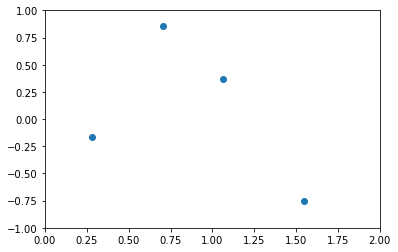

In [16]:
splat_positions = np.array([[splat.position[0], splat.position[1]] for splat in solution.splats])
plt.plot(splat_positions[:, 0], splat_positions[:, 1], "o");
plt.xlim(problem.domain_x);
plt.ylim(problem.domain_y);

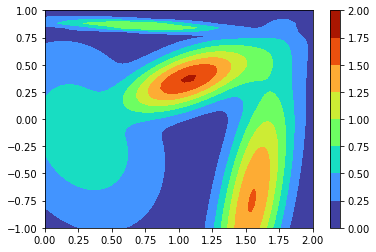

In [17]:
nx = 101
ny = 51
grid = problem.point_grid(nx, ny)
velocity_field = solution.velocity_on_grid(grid)
contour_x = np.array([grid[0, k, 0] for k in range(nx)])
contour_y = np.array([grid[j, 0, 1] for j in range(ny)])
velocity_magnitude = np.array([[np.linalg.norm(velocity_field[j, k, :]) for k in range(nx)] for j in range(ny)])
plt.contourf(contour_x, contour_y, velocity_magnitude, cmap="turbo");
plt.colorbar();

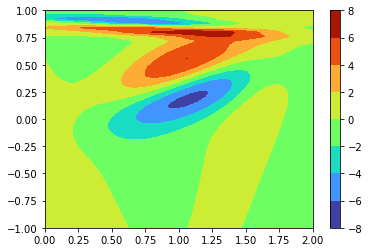

In [18]:
gradient_field = solution.velocity_gradient_on_grid(grid)
#velocity_gradient_norm = np.array([[np.linalg.norm(gradient_field[j, k, :]) for k in range(nx)] for j in range(ny)])
velocity_gradient_sum = np.array([[sum(gradient_field[j, k, :]) for k in range(nx)] for j in range(ny)])
plt.contourf(contour_x, contour_y, velocity_gradient_sum, cmap="turbo");
plt.colorbar();

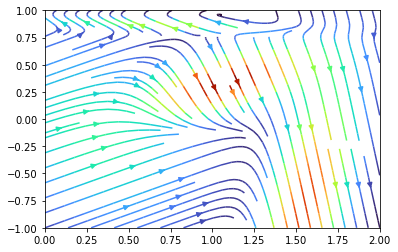

In [19]:
#print(solution.velocity_gradient_matrix_on_grid(nx, ny))
plt.streamplot(contour_x, contour_y, velocity_field[:, :, 0], velocity_field[:, :, 1], color=velocity_magnitude, cmap="turbo")

## Optimizer Class

In [ ]:
optimizer = AeroSplatOptimizer(problem, initial=solution)

print("initial loss evaluations", [optimizer.boundary_loss(), optimizer.volume_loss(), optimizer.loss()])

for k in range(10000):
    optimizer.iterate()

history = np.array(optimizer.history)

plt.semilogy(history[:, 0]);
#plt.semilogy(history[:, 1]);

print("final loss evaluations", [optimizer.boundary_loss(), optimizer.volume_loss(), optimizer.loss()])


initial loss evaluations [0.3369892521601861, 0.045930417463252445, 0.38026225879956665]


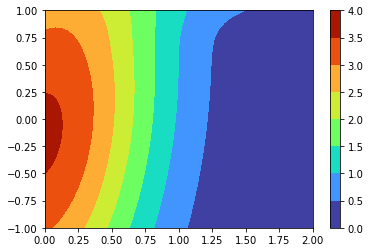

In [ ]:
final_solution = optimizer.solutions[-1]
velocity_field = final_solution.velocity_on_grid(grid)
velocity_magnitude = np.array([[np.linalg.norm(velocity_field[j, k, :]) for k in range(nx)] for j in range(ny)])
plt.contourf(contour_x, contour_y, velocity_magnitude, cmap="turbo");
plt.colorbar();

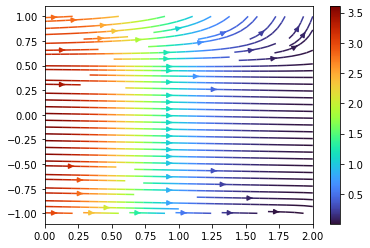

In [ ]:
plt.streamplot(contour_x, contour_y, velocity_field[:, :, 0], velocity_field[:, :, 1], color=velocity_magnitude, cmap="turbo")
plt.colorbar();

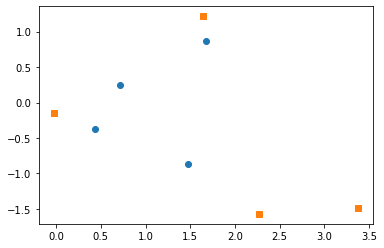

In [ ]:
final_splat_positions = np.array([[splat.position[0], splat.position[1]] for splat in final_solution.splats])
plt.plot(splat_positions[:, 0], splat_positions[:, 1], "o");
plt.plot(final_splat_positions[:, 0], final_splat_positions[:, 1], "s");
#plt.xlim(problem.domain_x);
#plt.ylim(problem.domain_y);